本文为跟随datawhale组队学习任务的一次尝试，初次完成一个完整的项目，在各方面经验都不足。若各位朋友指正代码和分析思路中的不成熟之处

任务说明：数据集是金融数据（非原始数据，已经处理过了），我们要做的是预测贷款用户是否会逾期。表格中 "status" 是结果标签：0表示未逾期，1表示逾期。

任务要求：数据切分方式 - 三七分，其中测试集30%，训练集70%，随机种子设置为2018
任务1：对数据进行探索和分析。
- 数据类型的分析
- 无关特征删除
- 数据类型转换
- 缺失值处理
- ……以及你能想到和借鉴的数据分析处理

# 数据类型的分析

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('C:\\Users\\付蓉\\Desktop\\data.csv',encoding="GBK")

In [3]:
data.head()

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 90 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

In [5]:
def overall(data):
    typedic= {} # 类型字典
    for name in data.columns:
        typedic[str(data[name].dtype)] = typedic.get(str(data[name].dtype),[])+[name]
    for key,value in typedic.items():
        # print('we have {} columns in type {}'.format(len(value),key))
        print('we have {} columns in type {}, they are {}\\'.format(len(value),key,value))

In [6]:
overall(data)

we have 13 columns in type int64, they are ['Unnamed: 0', 'custid', 'take_amount_in_later_12_month_highest', 'repayment_capability', 'is_high_user', 'historical_trans_amount', 'trans_amount_3_month', 'abs', 'avg_price_last_12_month', 'max_cumulative_consume_later_1_month', 'pawns_auctions_trusts_consume_last_1_month', 'pawns_auctions_trusts_consume_last_6_month', 'status']\
we have 7 columns in type object, they are ['trade_no', 'bank_card_no', 'reg_preference_for_trad', 'source', 'id_name', 'latest_query_time', 'loans_latest_time']\
we have 70 columns in type float64, they are ['low_volume_percent', 'middle_volume_percent', 'trans_amount_increase_rate_lately', 'trans_activity_month', 'trans_activity_day', 'transd_mcc', 'trans_days_interval_filter', 'trans_days_interval', 'regional_mobility', 'student_feature', 'number_of_trans_from_2011', 'first_transaction_time', 'historical_trans_day', 'rank_trad_1_month', 'avg_consume_less_12_valid_month', 'top_trans_count_last_1_month', 'avg_price

有7列是object类型，列名为['trade_no', 'bank_card_no', 'reg_preference_for_trad', 'source', 'id_name', 'latest_query_time', 'loans_latest_time']

# 无关特征删除

特征删除原则：
1. 在这组特征值上取值相同
2. 部分无意义数据，如用户姓名、用户编号等

In [7]:
len(data.columns)

90

In [8]:
def same_value_delete(data):
    for name in data.columns:
        if len(data[name].value_counts())==1:
            data.drop(name,axis = 1,inplace = True)

In [9]:
same_value_delete(data)

In [10]:
len(data.columns)

88

删去两列

下面观察对数据分析无帮助和无实际意义的数据

In [11]:
data['trade_no'].head()

0    20180507115231274000000023057383
1    20180507121002192000000023073000
2    20180507125159718000000023114911
3    20180507121358683000000388283484
4    20180507115448545000000388205844
Name: trade_no, dtype: object

交易号，与是否逾期无关。其中可能包含了交易时间，这一部分信息包含在表中latest_query_time等列

In [12]:
data.iloc[:,0].head()

0     5
1    10
2    12
3    13
4    14
Name: Unnamed: 0, dtype: int64

第一列数据，由于没有给出数据说明不清楚数据含义。暂时保留

In [13]:
data['custid'].head()

0    2791858
1     534047
2    2849787
3    1809708
4    2499829
Name: custid, dtype: int64

顾客号，同理无意义

In [14]:
data['student_feature'].value_counts(dropna=False)

NaN    2998
1.0    1754
2.0       2
Name: student_feature, dtype: int64

学生类型。本列缺失数据较多，缺失率达百分之六十多。考虑到可能与学生的贫困程度相关，在后续将把缺失值填补为“0”类型

In [15]:
data['id_name'].head()

0     蒋红
1    崔向朝
2    王中云
3    何洋洋
4     赵洋
Name: id_name, dtype: object

用户姓名，无意义

删去以上无意义的特征：

In [16]:
data.drop(['trade_no','custid','id_name'],inplace = True,axis = 1)

In [17]:
len(data.columns)

85

# 数值类型转换

In [18]:
overall(data)

we have 12 columns in type int64, they are ['Unnamed: 0', 'take_amount_in_later_12_month_highest', 'repayment_capability', 'is_high_user', 'historical_trans_amount', 'trans_amount_3_month', 'abs', 'avg_price_last_12_month', 'max_cumulative_consume_later_1_month', 'pawns_auctions_trusts_consume_last_1_month', 'pawns_auctions_trusts_consume_last_6_month', 'status']\
we have 70 columns in type float64, they are ['low_volume_percent', 'middle_volume_percent', 'trans_amount_increase_rate_lately', 'trans_activity_month', 'trans_activity_day', 'transd_mcc', 'trans_days_interval_filter', 'trans_days_interval', 'regional_mobility', 'student_feature', 'number_of_trans_from_2011', 'first_transaction_time', 'historical_trans_day', 'rank_trad_1_month', 'avg_consume_less_12_valid_month', 'top_trans_count_last_1_month', 'avg_price_top_last_12_valid_month', 'trans_top_time_last_1_month', 'trans_top_time_last_6_month', 'consume_top_time_last_1_month', 'consume_top_time_last_6_month', 'cross_consume_cou

现在仍有三列非数值型数据分别为['reg_preference_for_trad', 'latest_query_time', 'loans_latest_time']

In [19]:
# 城市类型
data['reg_preference_for_trad'].value_counts(dropna = False)

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
NaN        2
Name: reg_preference_for_trad, dtype: int64

将未知城市类型填充为其它城市

In [20]:
data['reg_preference_for_trad'].fillna('其他城市',inplace = True)

一线城市、二线、三线、境外、其他分别替换为1、2、3、4、5

In [21]:
data['reg_preference_for_trad'].replace({'一线城市':1,'二线城市':2,'三线城市':3,'境外':4,'其他城市':5},inplace = True)

data['latest_query_time', 'loans_latest_time']为日期型数据，在这里先保留不改

# 缺失值处理

首先来查看缺失值

In [62]:
data.isnull().sum()

Unnamed: 0                                  0
low_volume_percent                          2
middle_volume_percent                       2
take_amount_in_later_12_month_highest       0
trans_amount_increase_rate_lately           3
trans_activity_month                        2
trans_activity_day                          2
transd_mcc                                  2
trans_days_interval_filter                  8
trans_days_interval                         2
regional_mobility                           2
student_feature                          2998
repayment_capability                        0
is_high_user                                0
number_of_trans_from_2011                   2
first_transaction_time                      2
historical_trans_amount                     0
historical_trans_day                        2
rank_trad_1_month                           2
trans_amount_3_month                        0
avg_consume_less_12_valid_month             2
abs                               

<IPython.core.display.Javascript object>


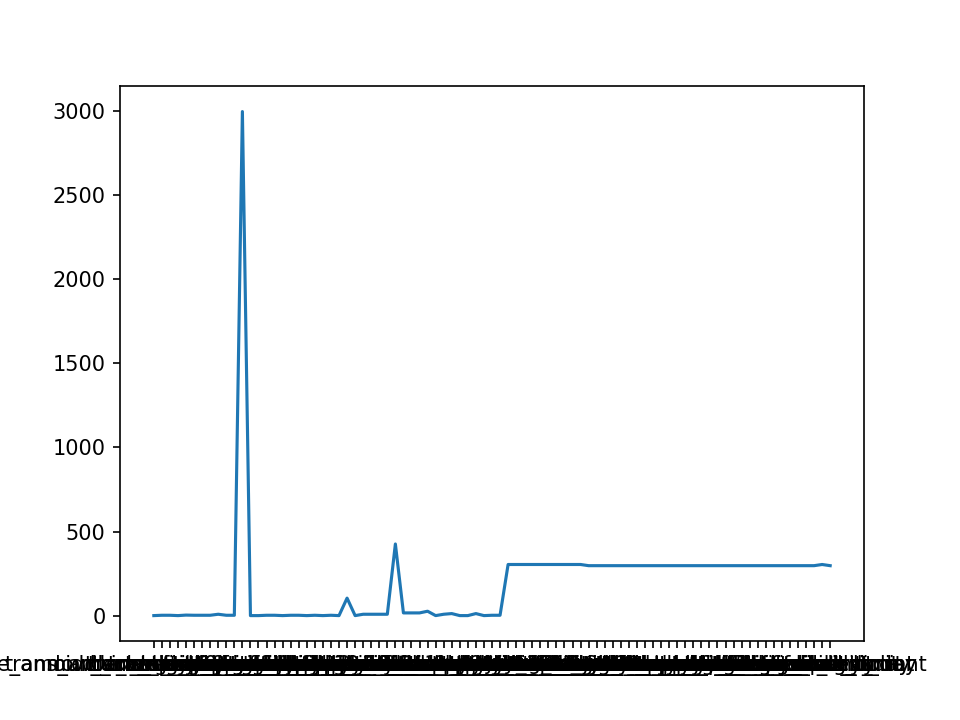

In [61]:
import matplotlib.pyplot as plt
plt.plot(data.isnull().sum())

学生类型处缺失数据较多，将空值填充为“0”型学生

In [63]:
data['student_feature'].fillna(0,inplace = True)

其它缺失数据均用均值填充，缺失特征数过多的数据直接丢弃

In [64]:
data.shape

(4754, 85)

In [67]:
data.dropna(thresh=3,inplace=True)

data.fillna(data.mean(),inplace = True)

最后看一下经过以上处理后的数据：

In [75]:
data.describe()

,Unnamed: 0,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
count,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,...,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000,4754.000000
mean,6008.414178,0.021806,0.901294,1940.197728,14.160674,0.804411,0.365425,17.502946,29.029920,21.751263,...,3390.038142,1820.357864,9187.009199,76.042630,4.732331,5.227507,16153.690823,8007.696881,24.112809,55.181512
std,3452.071428,0.041518,0.144826,3923.971494,693.961362,0.196879,0.170160,4.474675,22.703301,16.471449,...,1427.404361,564.896292,7137.238996,14.075313,2.880160,3.301056,13847.017251,5499.111964,36.499329,51.788355
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.120000,0.033000,2.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000
25%,3106.000000,0.010000,0.880000,0.000000,0.620000,0.670000,0.233000,15.000000,16.000000,12.000000,...,2400.000000,1560.000000,5000.000000,77.000000,3.000000,3.000000,7800.000000,4800.000000,6.000000,11.000000
50%,6006.500000,0.010000,0.960000,500.000000,0.970000,0.860000,0.350500,17.000000,23.000000,17.000000,...,3300.000000,1820.357864,8100.000000,78.000000,4.732331,5.000000,14400.000000,7283.500000,16.000000,43.000000
75%,8999.000000,0.020000,0.990000,2000.000000,1.600000,1.000000,0.479500,20.000000,32.000000,26.750000,...,4200.000000,2080.000000,11300.000000,80.000000,6.000000,7.000000,20400.000000,9696.250000,24.112809,86.000000
max,11992.000000,1.000000,1.000000,68000.000000,47596.740000,1.000000,0.941000,42.000000,285.000000,234.000000,...,10000.000000,6900.000000,87100.000000,87.000000,18.000000,20.000000,266400.000000,82800.000000,360.000000,323.000000


提出问题：
- 缺失率大于多少时应当抛弃该特征？
- 怎样判断离群值以及是否需要删除离群值或怎样替代离群值？（比如一些手动录入过程中出错产生的离群值等）
- 这里城市的分类显然不适合用独热码编码了，那么如果在其它时候使用data.preprocessing中的LabelBinarizer后重新编码的文本特征又怎样应用到预测中？